#### Binary Classification of Private/Public Label
Classify whether a given CDR3 sequence is Public or Private using different machine/deep learning models and compare the results.
The input CDR3 sequences are either embedded using CVC or converted to one-hot encoding.

In [1]:
cd ..

/home/romi/projects/cvc


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
import collections
import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import lab_notebooks.utils
import torch

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

SRC_DIR = "cvc"
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)
from cvc import model_utils
from lab_notebooks.utils import SC_TRANSFORMER, TRANSFORMER, DEVICE, DATA_DIR
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)

FILT_EDIT_DIST = True

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/CDR3_data_plots")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
PLOT_DIR

'plots/CDR3_data_plots'

In [4]:
DEVICE

device(type='cuda', index=0)


#### Load Data

In [5]:
# to load the embeddings from csv
load_csv = True

In [6]:
data_dir = DATA_DIR + "db_data_nuc_vj_genes_pub_priv.csv"
data_dir

'/home/romi/projects/cvc/CDR3_data/db_data_nuc_vj_genes_pub_priv.csv'

In [6]:
# read data
tcrb_data = pd.read_csv(data_dir, usecols=["Sequences", "Private_Public_label"], engine="pyarrow")
# drop duplicates
tcrb_data_filtered = tcrb_data.drop_duplicates()
len(tcrb_data_filtered.index)

91758697

In [17]:
tcrb_data_filtered

,Sequences,Private_Public_label
0,CASSLGETQYF,1
16658,CASSLGYEQYF,1
30397,CASSLGGNTEAFF,1
43085,CASSSSYEQYF,1
54734,CASSLQETQYF,1
...,...,...
199455315,CAWNAGTEANQPQHF,0
199455316,CARGEGATLGGRVYFDYW,0
199455317,CASSVHRLRTEAFF,0
199455318,CSASTTERGNTDTQYF,0


In [7]:
collections.Counter(tcrb_data_filtered['Private_Public_label'])

Counter({1: 17562246, 0: 74196451})

#### Split Public/Private into equal groups

In [8]:
# For db Data
NUM_TO_SAMPLE = 100000
# sample equal number of private and public
public_sample = tcrb_data_filtered.query('Private_Public_label == 1').sample(NUM_TO_SAMPLE)
private_sample = tcrb_data_filtered.query('Private_Public_label == 0').sample(NUM_TO_SAMPLE)

In [ ]:
# join public and private samples
tcrb_data_sample = pd.concat([public_sample, private_sample])
tcrb_data_sample

In [10]:
# convert label column to numpy array
private_public_label_array = tcrb_data_sample['Private_Public_label'].to_numpy()
print(private_public_label_array)

[1 1 1 ... 0 0 0]


In [ ]:
from cvc.embbeding_wrapper import EmbeddingWrapper
# Create embeddings
embed_wrap = EmbeddingWrapper(TRANSFORMER, DEVICE, sequences_df=tcrb_data_sample, batch_size=256, method="mean", layers=[-1], pbar=True, max_len=64)
embed_wrap.embeddings.shape

In [ ]:
# create anndata object
tcrb_embeddings_adata = embed_wrap.create_anndata()
# embeddings df
df_embeddings = pd.DataFrame(embed_wrap.embeddings)

In [ ]:
# add public/private label to dataframe
df_embeddings_with_label = df_embeddings
df_embeddings_with_label['Private_Public_label']=list(tcrb_embeddings_adata.obs['Private_Public_label'])
df_embeddings_with_label['Sequences']=list(tcrb_embeddings_adata.obs['Sequences'])

In [ ]:
# export embeddings to csvֿ
df_embeddings_with_label.to_csv('./db_data_embeddings_with_label.csv')

In [7]:
# load from csv
if load_csv==True:
    df_embeddings_with_label = pd.read_csv('./db_data_embeddings_with_label.csv')
tcrb_embeddings = df_embeddings_with_label.iloc[:,1:-2].to_numpy()
private_public_label_array = df_embeddings_with_label.iloc[:,-2].to_numpy()

#### Binary Classification Utils

In [8]:
TRAIN_RATIO = 0.8

def split_train_test(embeddings, embedding_labels):
    #import pdb; pdb.set_trace()
    # The data will be divided into 80% training 20% validation
    idx_train = int(len(embeddings) * TRAIN_RATIO)

    indices = np.arange(embeddings.shape[0])

    # Shuffle data
    np.random.shuffle(indices)

    # Separate the images and the labels
    embeddings_shuffle = embeddings[indices] 
    embedding_labels_shuffle = embedding_labels[indices]

    # Split to train and validation
    train_embeddings = embeddings_shuffle[:idx_train]
    train_labels = embedding_labels_shuffle[:idx_train]
    validation_embeddings = embeddings_shuffle[idx_train:]
    validation_labels = embedding_labels_shuffle[idx_train:]
    
    return train_embeddings, train_labels, validation_embeddings, validation_labels

In [9]:
# run if data was read from a csv
embeddings = tcrb_embeddings
embedding_labels = private_public_label_array
print("shape of embeddings: {}\nshape of embedding_labels: {}".format(embeddings.shape,embedding_labels.shape))

shape of embeddings: (200000, 768)
shape of embedding_labels: (200000,)


In [10]:
train_embeddings, embed_train_labels, validation_embeddings, embed_validation_labels = split_train_test(embeddings, embedding_labels)
train_embeddings.shape, embed_train_labels.shape, validation_embeddings.shape, embed_validation_labels.shape

((160000, 768), (160000,), (40000, 768), (40000,))

In [11]:
# check that the data is even
collections.Counter(embed_validation_labels), collections.Counter(embed_train_labels)

(Counter({0: 19875, 1: 20125}), Counter({0: 80125, 1: 79875}))

#### One-Hot Encoding

In [29]:
# Import Dependencies 
import pandas as pd
import numpy as np
import torch.nn.functional as F

# Function to encode sequences
def encode_seq(sequence, max_cdr3_len):
    alphabet = ['A', 'C', 'D', 'E', 'F', 'G','H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    integer_encoded = [char_to_int[char] for char in sequence]
    
    # one hot encode
    integer_encoded = torch.tensor(integer_encoded)
    integer_encoded = F.one_hot(integer_encoded, num_classes=len(alphabet))
    
    # pad integer_encoded tensor first dim with zeros up to max_cdr3_len
    integer_encoded = F.pad(integer_encoded, (0,0,0, max_cdr3_len - len(integer_encoded)))
    
    integer_encoded = integer_encoded.numpy()

    return integer_encoded

In [30]:
# extract sequences
cdr3_sequences = df_embeddings_with_label['Sequences']#tcrb_data_sample['Sequences']
sequences_labels = private_public_label_array
max_cdr3_len = cdr3_sequences.apply(len).max()
max_cdr3_len

31

In [31]:
# split data into train/test
train_seqs, train_labels, validation_seqs, validation_labels = split_train_test(cdr3_sequences.to_numpy(), sequences_labels)
print("shape of training set: {}\nshape of validation set: {}".format(train_seqs.shape, validation_seqs.shape))

shape of training set: (160000,)
shape of validation set: (40000,)


In [32]:
# encode amino acid sequences to one hot vector
encoded_train_seqs = pd.Series(train_seqs).apply(lambda x: encode_seq(x, max_cdr3_len))
encoded_validation_seqs = pd.Series(validation_seqs).apply(lambda x: encode_seq(x, max_cdr3_len))

In [33]:
# check to see even distribution between public and private
collections.Counter(validation_labels)

Counter({0: 20081, 1: 19919})

In [34]:
# Stack list(encoded_train_seqs) in dim 0
train_seqs_stack = np.stack(encoded_train_seqs, axis=0)
valid_seqs_stack = np.stack(encoded_validation_seqs, axis=0)
train_seqs_stack.shape, valid_seqs_stack.shape

((160000, 31, 20), (40000, 31, 20))

In [35]:
# reshape train/validation tensors
train_seqs_stack = train_seqs_stack.reshape(train_seqs_stack.shape[0], -1)
valid_seqs_stack = valid_seqs_stack.reshape(valid_seqs_stack.shape[0], -1)
train_seqs_stack.shape, valid_seqs_stack.shape

((160000, 620), (40000, 620))

#### xgBoost on Embeddings
Guide on xgBoost - https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390

In [ ]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_embeddings = sc.fit_transform(train_embeddings)
validation_embeddings = sc.fit_transform(validation_embeddings)

In [27]:
# extract accuracy
accuracy_xgb, xgb_preds, xgb_classifier = \
    lab_notebooks.utils.xgb_classify(train_embeddings, embed_train_labels, validation_embeddings, embed_validation_labels)
accuracy_xgb

0.81185

In [ ]:
# plot the roc curve for the model
# get probabilities
probs = xgb_classifier.predict_proba(validation_embeddings)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(embed_validation_labels, probs[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

#### xgBoost - One-Hot

In [36]:
# apply xgb on onehot, extract accuracy
accuracy_xgb_onehot, xgb_preds_onehot, xgb_classifier_onehot =\
    lab_notebooks.utils.xgb_classify(train_seqs_stack, train_labels, valid_seqs_stack, validation_labels)

# get probabilities and roc
probs = xgb_classifier_onehot.predict_proba(valid_seqs_stack)
fpr_onehot_xgb, tpr_onehot_xgb, thresholds_onehot_xgb = roc_curve(validation_labels, probs[:, 1])
roc_auc_onehot_xgb = auc(fpr_onehot_xgb, tpr_onehot_xgb)

accuracy_xgb_onehot

0.73875

### LDA

In [37]:
# apply LDA
accuracy_lda, lda_preds, lda_classifier = lab_notebooks.utils.lda_classify(train_embeddings,embed_train_labels, validation_embeddings, embed_validation_labels)

In [38]:
# plot the roc curve for the model
# get probabilities
probs = lda_classifier.predict_proba(validation_embeddings)
fpr_lda, tpr_lda, thresholds_lda = roc_curve(embed_validation_labels, probs[:, 1])
roc_auc_lda = auc(fpr_lda, tpr_lda)

accuracy_lda

0.82035

### LDA - OneHot

In [39]:
accuracy_lda_onehot, lda_preds_onehot, lda_classifier_onehot =\
    lab_notebooks.utils.xgb_classify(train_seqs_stack, train_labels, valid_seqs_stack, validation_labels)

probs_oh_lda = lda_classifier_onehot.predict_proba(valid_seqs_stack)
fpr_onehot_lda, tpr_onehot_lda, thresholds_onehot_lda = roc_curve(validation_labels, probs_oh_lda[:, 1])
roc_auc_onehot_lda = auc(fpr_onehot_lda, tpr_onehot_lda)

accuracy_lda_onehot

0.696075

## Deep Neural Network

#### Deep Learning Model on Embeddings

In [12]:
# set flag to run with onehot
DNN_ONEHOT = 0

In [13]:
# defining dataset class
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
    def __init__(self,x, y):
        # self.x = torch.tensor(x, dtype=torch.float32).to('cuda')
        # self.y = torch.tensor(y, dtype=torch.float32).to('cuda')
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.length = self.x.shape[0]
        assert self.x.shape[0] == self.y.shape[0]
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.length

In [14]:
BATCH_SIZE = 1024

# create datasets
if DNN_ONEHOT==0:
    trainset = dataset(train_embeddings, embed_train_labels)
    validset = dataset(validation_embeddings, embed_validation_labels)
else:
    trainset = dataset(train_seqs_stack, train_labels)
    validset = dataset(valid_seqs_stack, validation_labels)

# DataLoader with 10 workers
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=10, pin_memory=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, num_workers=10, pin_memory=True)

In [15]:
# defining the network
from torch import nn
from torch.nn import functional as F

class Net(nn.Module):
    def __init__(self, input_shape):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape,128)
        self.fc2 = nn.Linear(128,32)
        self.fc3 = nn.Linear(32,1)
    
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [16]:
# hyper parameters
learning_rate = 0.00001 # 1e-6

# set input shape
input_shape = train_embeddings.shape[1]
if DNN_ONEHOT:
    input_shape = train_seqs_stack.shape[1]

# Model , Optimizer, Loss
device = 'cpu'
model = Net(input_shape=input_shape).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [18]:
def calculate_accuracy(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)
    y_test = y_test.unsqueeze(1)
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [19]:
def train_classify(model, trainloader, optimizer):
    epoch_loss = 0
    epoch_acc = 0
    count = 0
    model.train()
    for train_embedding, train_label in tqdm.notebook.tqdm(trainloader, total=len(trainloader)):
        # option to move train_embedding, train_label to gpu here
        # calculate output
        train_embedding, train_label =  train_embedding.to(device), train_label.to(device)
        output = model(train_embedding)
        
        # calculate loss
        loss = loss_fn(output, train_label.reshape(-1,1))
        
        # accuracy
        acc = calculate_accuracy(output, train_label)
        
        # backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        count += len(train_label)
        
    return epoch_loss / len(trainloader), epoch_acc / len(trainloader)

In [20]:
def evaluate_classify(model, validloader): 
    epoch_loss = 0
    epoch_acc = 0
    count = 0
    model.eval()
    label_list = []
    pred_label_list = []
    with torch.no_grad(): 
        for valid_embedding, valid_label in tqdm.notebook.tqdm(validloader, total=len(validloader)):
            # option to move valid_embedding, valid_label to gpu here
            valid_embedding, valid_label = valid_embedding.to(device), valid_label.to(device)
            # calculate output
            output = model(valid_embedding)

            # calculate loss
            loss = loss_fn(output, valid_label.reshape(-1,1))

            # accuracy
            acc = calculate_accuracy(output, valid_label)
            
            # add to lists for confusion matrixv
            label_list.append(valid_label.cpu())
            pred_label_list.append(output.cpu())
            
            #acc = calculate_accuracy(output, valid_label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            count += len(valid_label)
    return (epoch_loss / len(validloader), epoch_acc / len(validloader),
            torch.cat(label_list, dim=0), 
            torch.cat(pred_label_list, dim=0))

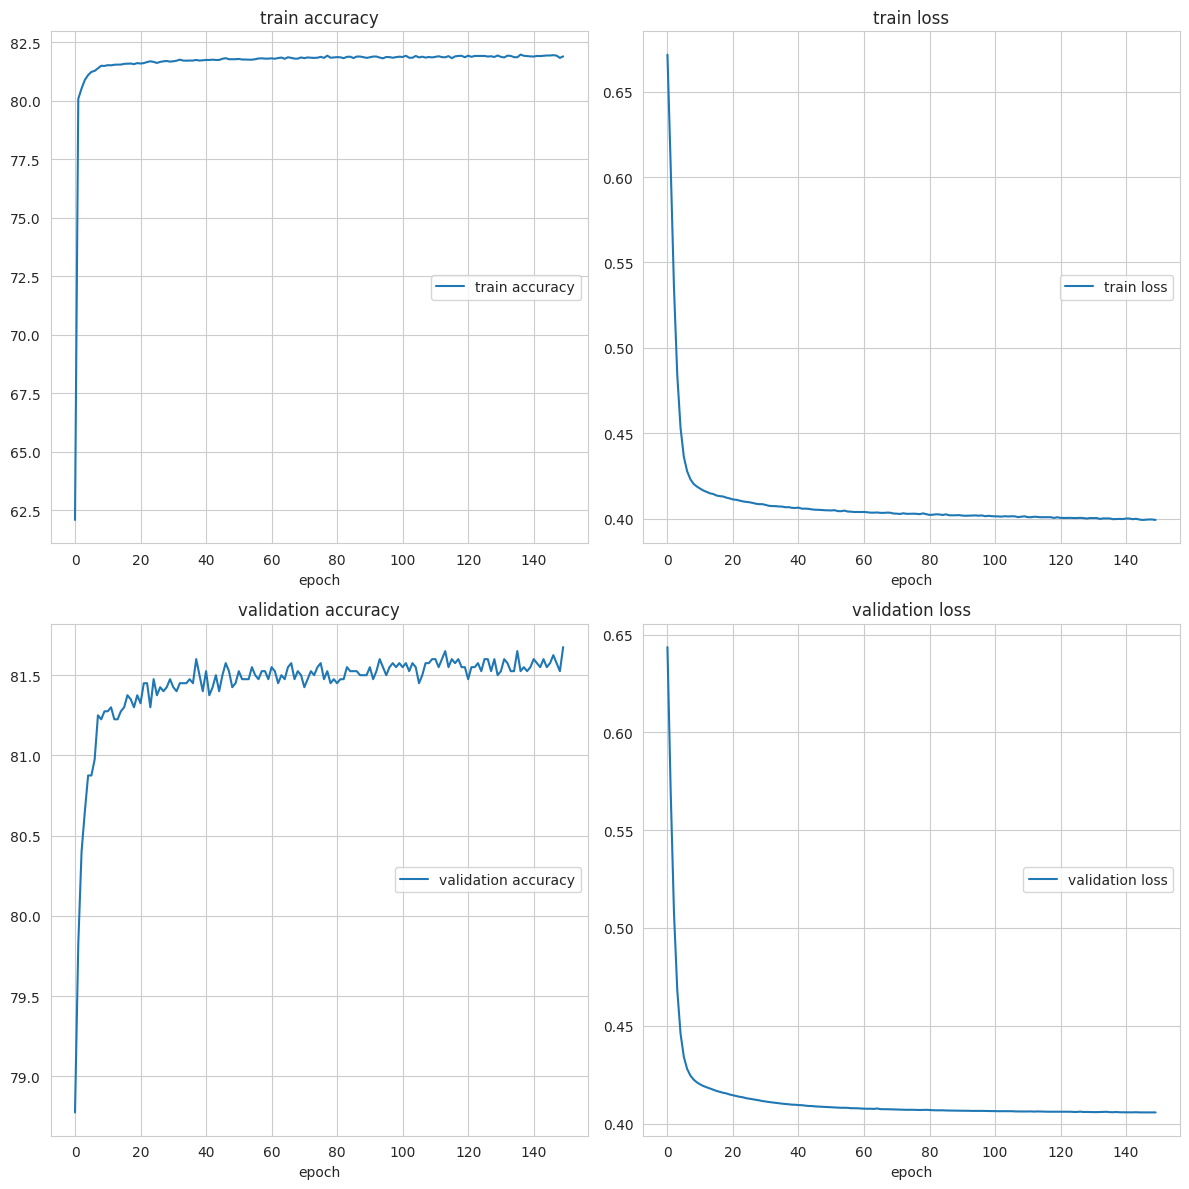

train accuracy
	train accuracy   	 (min:   62.076, max:   81.962, cur:   81.885)
train loss
	train loss       	 (min:    0.399, max:    0.672, cur:    0.399)
validation accuracy
	validation accuracy 	 (min:   78.775, max:   81.675, cur:   81.675)
validation loss
	validation loss  	 (min:    0.406, max:    0.644, cur:    0.406)


In [21]:
from livelossplot import PlotLosses

liveloss1_class = PlotLosses()
logs_class = {}
EPOCHS=150

for epoch in range(EPOCHS):
    print('starting epoch {}'.format(epoch))
    train_loss, train_acc = train_classify(model, trainloader, optimizer)
    print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, EPOCHS, train_loss))
    
    print('Epoch {} of {}, Train Accuracy: {:.3f}'.format(
          epoch+1, EPOCHS, train_acc))
    
    logs_class['train loss'] = train_loss
    logs_class['train accuracy'] = train_acc

    valid_loss, valid_acc, label_list, pred_label_list  = evaluate_classify(model, validloader)
    print('Epoch {} of {}, Validate Loss: {:.3f}'.format(
        epoch+1, EPOCHS, valid_loss))
    
    print('Epoch {} of {}, Validate Accuracy: {:.3f}'.format(
        epoch+1, EPOCHS, valid_acc))

    logs_class['validation loss'] = valid_loss
    logs_class['validation accuracy'] = valid_acc
        
    liveloss1_class.update(logs_class)
    liveloss1_class.send()

In [22]:
# Save model
PATH = "./classifiers/private_public_classifier.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, PATH)

##### Analyse results

In [ ]:
# get predictions from model
label_list = []
pred_label_list = []
_, _, label_list, pred_label_list = evaluate_classify(model, validloader)

In [ ]:
preds, labels = pred_label_list[:, 0].cpu().numpy(), label_list.unsqueeze(1)[:, 0].cpu().numpy()
preds_at_threshold_05 = (preds > 0.5).astype(int)
labels = labels.astype(int)

In [ ]:
# calculate FN, TP, TN, FP 
tn_nn, fp_nn, fn_nn, tp_nn = confusion_matrix(preds_at_threshold_05, labels).ravel()

labels_vals = [tn_nn, fp_nn, fn_nn, tp_nn]
labels_TF = [f"True Negative","False Positive","False Negative","True Positive"]
sum_all = tn_nn + fp_nn + fn_nn + tp_nn

labels_vals_str = [str(round(val/sum_all, 4)*100) for val in labels_vals]
labels_TF_final = [f"{label}\n{label_val_str}%" for label, label_val_str in zip(labels_TF, labels_vals_str)]

In [ ]:
labels_TF_final = [[labels_TF_final[0], labels_TF_final[1]], [labels_TF_final[2], labels_TF_final[3]]]

In [ ]:
# calculate confusion matrix
confusion_mat_val = confusion_matrix(preds_at_threshold_05, label_list.cpu().numpy())
labels_TF = np.asarray(labels_TF).reshape(2,2)
plt.figure(figsize = (10,7))
sns.heatmap(confusion_mat_val, annot=labels_TF_final, fmt="", cmap='RdPu')

In [ ]:
# roc data for DNN
if DNN_ONEHOT==0:
    fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(embed_validation_labels, preds)
    roc_auc_dnn = auc(fpr_dnn, tpr_dnn)
else:
    fpr_onehot_dnn, tpr_onehot_dnn, thresholds_onehot_dnn = roc_curve(validation_labels, preds)
    roc_auc_onehot_dnn = auc(fpr_onehot_dnn, tpr_onehot_dnn)

#### ROC of all algorithms

In [ ]:
plt.plot(fpr_lda, tpr_lda, color='red',
         label='LDA (area = %0.2f)' % roc_auc_lda)
plt.plot(fpr_xgb, tpr_xgb, color='blue',
         label='xgBoost (area = %0.2f)' % roc_auc_xgb)
plt.plot(fpr_dnn, tpr_dnn, color='green',
         label='Simple DNN (area = %0.2f)' % roc_auc_dnn)
plt.plot(fpr_onehot_xgb, tpr_onehot_xgb, color='lightblue',
         label='xgBoost one-hot (area = %0.2f)' % roc_auc_onehot_xgb)
plt.plot(fpr_onehot_lda, tpr_onehot_lda, color='pink',
         label='LDA one-hot (area = %0.2f)' % roc_auc_onehot_lda)
plt.plot(fpr_onehot_dnn, tpr_onehot_dnn, color='lightgreen',
         label='Simple DNN one-hot (area = %0.2f)' % roc_auc_onehot_dnn)
# Set axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Set title
# plt.title('An ROC Presenting Supervised Classification of Public and Private Sequences')
# Set plot legend
plt.legend(loc="lower right")
# Show plot
plt.show()